In [2]:
using CSV, JuMP, Ipopt, Statistics, Distributions, 
      Plots, GLM, DataFrames, Suppressor

In [3]:
struct RDData
    y::Array{Float64}
    x::Array{Float64}
    M::Float64
    sig2::Float64 
    xx::Array
    d::Int
    mu::Array
    n::Array
    h::Float64
    c0::Int
    c1::Int
end

function RDData(y, x, M) 
    xx = sort!(unique(x))
    d = length(xx) 
    c0 = argmin(abs.(xx))
    c1 = c0 + 1 
    h = minimum(xx[2:d].- xx[1:(d-1)])
    data = DataFrame(y=y, x=x, w= x.>0)
    yhat = predict(lm(@formula(y~x*w),data))
    sig2 = mean((data[:y] - yhat).^2) * length(data[:x]) / (length(data[:x]) - 4)
    
    mu = zeros(d)
    n = zeros(d)
    
    for i in 1:d
        mu[i] = mean(y[x.==xx[i]])
        n[i] = length(x[x.==xx[i]])
    end
    return RDData(y, x, M, sig2, xx, d, mu, n, h, c0, c1)
end

RDData

In [94]:
data = CSV.read("data/cleaned/jl_math.csv")
M = 1.74
rd = RDData(data[:y], data[:x], 1.74)
vg = optimize_weights(rd, 1000)

-0.27294808395199016
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       68
Number of nonzeros in inequality constraint Jacobian.:  4693068
Number of nonzeros in Lagrangian Hessian.............:  2346000

Total number of variables............................:       69
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        2
Total number of inequality constraints...............:     1068
        inequality constraints with only lower bounds:     1027
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       41

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_

68-element Array{Float64,1}:
 -8.205680620310735e-9  
 -7.045785345792088e-9  
 -6.803480912690512e-9  
  7.393237225034875e-10 
 -6.901431897374719e-9  
  9.025916284358798e-6  
 -8.218048318097828e-9  
  1.9083903137631823e-6 
  2.0162583939890966e-5 
  1.6681398159520428e-5 
  2.9044550795662933e-5 
 -8.241878744825698e-9  
  3.0817920679700345e-5 
  ⋮                     
 -0.00011383344644036342
 -9.496976567749422e-5  
 -0.0001349361331974555 
 -0.00039226532908358816
 -0.0002122517581774896 
 -0.0004342500403884898 
 -0.0008058242089796877 
 -0.00176247207974419   
 -0.002576703041398859  
 -0.002969321887130581  
 -0.013677416821498764  
 -0.007149344520123104  

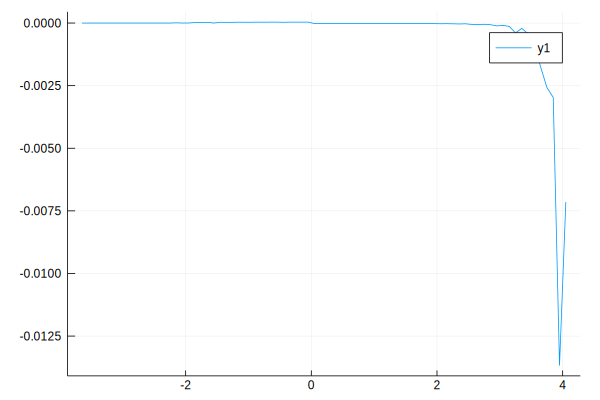

In [95]:
plot(rd.xx, vg)

In [81]:
sum(rd.n[1:rd.c0].*vg[1:rd.c0])
#sum(rd.n[rd.c1:rd.d].*vg[rd.c1:rd.d])

1.0

In [96]:
println(sum(vg.*rd.mu.*rd.n))

-1.3965125653079051


In [ ]:
mu, n = bin_subsample(data[:y], data[:x])

In [31]:
function bin_subsample(y, x, pct = 1)
    xx = sort!(unique(x))
    d = length(xx)
    
    ns = Int(floor(pct*length(y)))
    sampled = rand(1:length(y), ns)
    mu = zeros(d)
    n = zeros(d)
    ys = y[sampled]
    xs = x[sampled] 
    for i in 1:d
        if sum(xs.==xx[i]) >0 
            mu[i] = mean(ys[xs.==xx[i]])
            n[i] = length(xs[xs.==xx[i]])
        end 
    end
    return mu, n 
end

bin_subsample (generic function with 2 methods)

In [93]:
function optimize_weights(rd, S=100)
    #first draw uniformly based on max and min possible 
    #values of mu
    d = rd.d
    bh1 = rd.M*rd.h^2 - rd.mu[rd.c1+1] + 2*rd.mu[rd.c1]
    bl1 = -rd.M*rd.h^2 - rd.mu[rd.c1+1] + 2*rd.mu[rd.c1] 
    bh0 = 2*rd.mu[rd.c0] - rd.mu[rd.c0-1] + rd.h^2*rd.M
    bl0 = 2*rd.mu[rd.c0] - rd.mu[rd.c0-1] - rd.h^2*rd.M 
    
    mu0 = rand(Uniform(bl0, bh0), S)
    mu1 = rand(Uniform(bl1, bh1), S) 
    
    println(mean(mu1.-mu0))
    model = Model(with_optimizer(Ipopt.Optimizer))
    @variable(model, gamma[1:d])
    @variable(model, t)
    
    #identification constraints (sum to 1)
    @constraint(model, sum(rd.n[i]*gamma[i] for i in 1:rd.c0)==1)
    @constraint(model, sum(rd.n[i]*gamma[i] for i in rd.c1:d)==-1)
    #@constraint(model, sum(rd.n[i]*gamma[i]*rd.xx[i] for i in 1:d)==0)

    @constraint(model, gamma[1:rd.c0].>=0)
    @constraint(model, gamma[rd.c1:d].<=0)
    for a in 1:d
        if abs(a-rd.c0)>10
            #@constraint(model, gamma[a]==0)
        end
    end
    
    for s in 1:S
        mus, ns = bin_subsample(rd.y, rd.x)
        @constraint(model, t >= 100*rd.sig2*sum(rd.n[i]*gamma[i]^2 for i in 1:d)
            + (sum(rd.mu[i]*gamma[i]*rd.mu[i] for i in 1:d)-mu1[s]+mu0[s])^2)
    end
    
    @NLobjective(model,Min,t) 
    optimize!(model)
    vg = value.(gamma)
    return vg 

end


optimize_weights (generic function with 2 methods)